In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the two datasets
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

print("Trades shape:", trades.shape)
print("Sentiment shape:", sentiment.shape)

# Display column names for reference
print("\nTrades columns:", trades.columns.tolist())
print("\nSentiment columns:", sentiment.columns.tolist())


Trades shape: (211224, 16)
Sentiment shape: (2644, 4)

Trades columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Sentiment columns: ['timestamp', 'value', 'classification', 'date']


In [3]:

trades['datetime'] = pd.to_datetime(trades['Timestamp IST'], format="%d-%m-%Y %H:%M", errors='coerce')

# Convert sentiment 'Date' column to datetime
sentiment['datetime'] = pd.to_datetime(sentiment['date'], errors='coerce')

# Drop rows with missing datetime values
trades = trades.dropna(subset=['datetime'])
sentiment = sentiment.dropna(subset=['datetime'])

# Extract only the date (for daily grouping)
trades['date'] = trades['datetime'].dt.date
sentiment['date'] = sentiment['datetime'].dt.date

print(" Date parsing complete.")
print("Sample trade dates:", trades['date'].unique()[:5])
print("Sample sentiment dates:", sentiment['date'].unique()[:5])


 Date parsing complete.
Sample trade dates: [datetime.date(2024, 12, 2) datetime.date(2024, 12, 3)
 datetime.date(2024, 12, 4) datetime.date(2025, 3, 4)
 datetime.date(2025, 3, 5)]
Sample sentiment dates: [datetime.date(2018, 2, 1) datetime.date(2018, 2, 2)
 datetime.date(2018, 2, 3) datetime.date(2018, 2, 4)
 datetime.date(2018, 2, 5)]


In [4]:

# Clean numeric columns
trades['Closed PnL'] = pd.to_numeric(trades['Closed PnL'], errors='coerce')
trades['Size USD'] = pd.to_numeric(trades['Size USD'], errors='coerce')
if 'leverage' in trades.columns:
    trades['leverage'] = pd.to_numeric(trades['leverage'], errors='coerce')

# Group by date and compute summary metrics
daily_metrics = (
    trades.groupby('date')
    .agg(
        num_trades=('Closed PnL', 'count'),
        total_pnl=('Closed PnL', 'sum'),
        mean_pnl=('Closed PnL', 'mean'),
        median_pnl=('Closed PnL', 'median'),
        win_rate=('Closed PnL', lambda x: (x > 0).mean()),
        avg_size=('Size USD', 'mean'),
        avg_leverage=('leverage', 'mean') if 'leverage' in trades.columns else ('Size USD', 'mean')
    )
    .reset_index()
)

print(" Daily metrics calculated.")
print(daily_metrics.head())


 Daily metrics calculated.
         date  num_trades   total_pnl   mean_pnl  median_pnl  win_rate  \
0  2023-05-01           3    0.000000   0.000000    0.000000  0.000000   
1  2023-12-05           9    0.000000   0.000000    0.000000  0.000000   
2  2023-12-14          11 -205.434737 -18.675885    0.000000  0.363636   
3  2023-12-15           2  -24.632034 -12.316017  -12.316017  0.000000   
4  2023-12-16           3    0.000000   0.000000    0.000000  0.000000   

       avg_size  avg_leverage  
0    159.000000    159.000000  
1   5556.203333   5556.203333  
2  10291.213636  10291.213636  
3   5304.975000   5304.975000  
4   5116.256667   5116.256667  


In [5]:
#  — Merge Trader Metrics with Sentiment


# Select only necessary columns from sentiment dataset
sentiment_subset = sentiment[['date', 'classification']]
if 'Value' in sentiment.columns or 'value' in sentiment.columns:
    val_col = 'Value' if 'Value' in sentiment.columns else 'value'
    sentiment_subset[val_col] = sentiment[val_col]

# Merge on date
merged = pd.merge(daily_metrics, sentiment_subset, on='date', how='left')

print("Merge complete. Merged shape:", merged.shape)
print(merged.head())


Merge complete. Merged shape: (480, 10)
         date  num_trades   total_pnl   mean_pnl  median_pnl  win_rate  \
0  2023-05-01           3    0.000000   0.000000    0.000000  0.000000   
1  2023-12-05           9    0.000000   0.000000    0.000000  0.000000   
2  2023-12-14          11 -205.434737 -18.675885    0.000000  0.363636   
3  2023-12-15           2  -24.632034 -12.316017  -12.316017  0.000000   
4  2023-12-16           3    0.000000   0.000000    0.000000  0.000000   

       avg_size  avg_leverage classification  value  
0    159.000000    159.000000          Greed   63.0  
1   5556.203333   5556.203333  Extreme Greed   75.0  
2  10291.213636  10291.213636          Greed   72.0  
3   5304.975000   5304.975000          Greed   70.0  
4   5116.256667   5116.256667          Greed   67.0  


C:\Users\hitar\AppData\Local\Temp\ipykernel_18252\1634644797.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sentiment_subset[val_col] = sentiment[val_col]



=== Performance Summary by Sentiment Classification ===
                avg_total_pnl  median_total_pnl  avg_win_rate  avg_num_trades
classification                                                               
Extreme Fear     52793.589178      22561.739636      0.327341     1528.571429
Fear             36891.818040       1412.314654      0.329112      679.527473
Extreme Greed    23817.292199       3127.536297      0.467424      350.807018
Neutral          19297.323516       1818.573295      0.331886      562.477612
Greed            11140.566181        678.475928      0.335986      260.637306


C:\Users\hitar\AppData\Local\Temp\ipykernel_7976\2830771658.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sentiment_summary.reset_index(), x='classification', y='avg_total_pnl', palette='coolwarm')


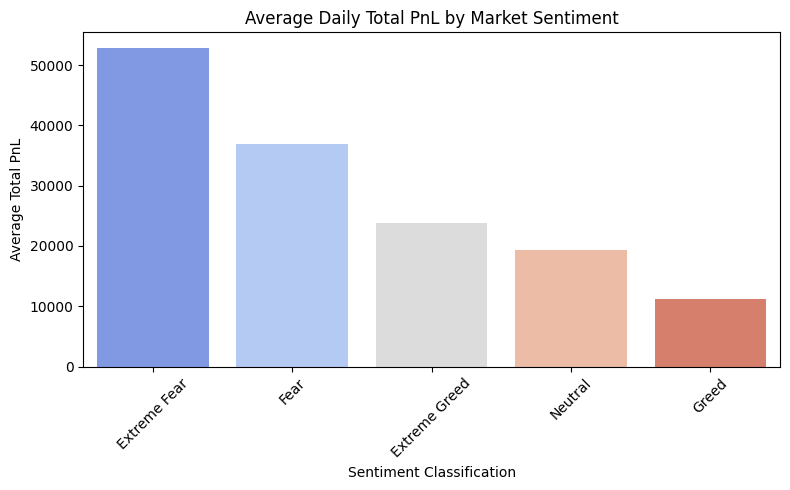

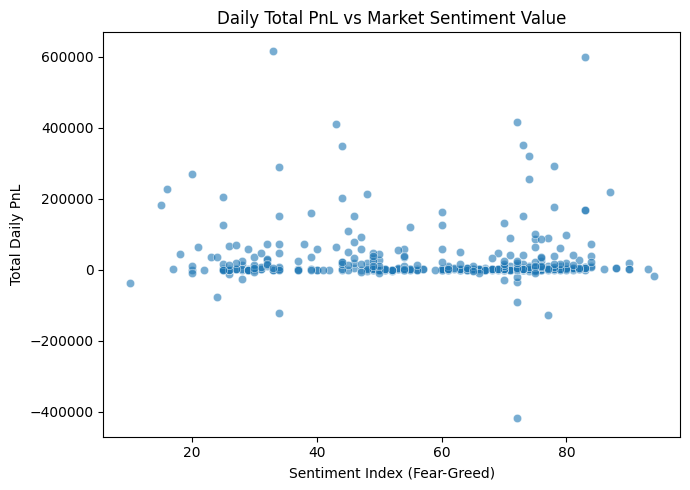

In [15]:
# — Exploratory Data Analysis

sentiment_summary = (
    merged.groupby('classification')
    .agg(
        avg_total_pnl=('total_pnl', 'mean'),
        median_total_pnl=('total_pnl', 'median'),
        avg_win_rate=('win_rate', 'mean'),
        avg_num_trades=('num_trades', 'mean')
    )
    .sort_values(by='avg_total_pnl', ascending=False)
)

print("\n=== Performance Summary by Sentiment Classification ===")
print(sentiment_summary)

# Plot: Average total PnL by sentiment
plt.figure(figsize=(8,5))
sns.barplot(data=sentiment_summary.reset_index(), x='classification', y='avg_total_pnl', palette='coolwarm')
plt.title('Average Daily Total PnL by Market Sentiment')
plt.xlabel('Sentiment Classification')
plt.ylabel('Average Total PnL')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Scatter between sentiment value and total pnl (if value exists)
if 'Value' in merged.columns or 'value' in merged.columns:
    val_col = 'Value' if 'Value' in merged.columns else 'value'
    plt.figure(figsize=(7,5))
    sns.scatterplot(data=merged, x=val_col, y='total_pnl', alpha=0.6)
    plt.title('Daily Total PnL vs Market Sentiment Value')
    plt.xlabel('Sentiment Index (Fear-Greed)')
    plt.ylabel('Total Daily PnL')
    plt.tight_layout()
    plt.show()


In [16]:
#  Correlation and Significance Tests

from scipy.stats import pearsonr, spearmanr

# Identify sentiment numeric column 
val_col = 'Value' if 'Value' in merged.columns else 'value'

metrics = ['total_pnl', 'mean_pnl', 'win_rate', 'num_trades', 'avg_leverage']
correlation_results = []

for m in metrics:
    valid = merged[[val_col, m]].dropna()
    if len(valid) > 10:
        pearson_r, pearson_p = pearsonr(valid[val_col], valid[m])
        spearman_r, spearman_p = spearmanr(valid[val_col], valid[m])
        correlation_results.append([m, pearson_r, pearson_p, spearman_r, spearman_p])

corr_df = pd.DataFrame(correlation_results,
                       columns=['Metric', 'Pearson_r', 'Pearson_p', 'Spearman_r', 'Spearman_p'])

print("=== Sentiment Correlation Results ===")
print(corr_df.sort_values(by='Pearson_r', ascending=False))


=== Sentiment Correlation Results ===
         Metric  Pearson_r     Pearson_p  Spearman_r  Spearman_p
2      win_rate   0.152485  8.134376e-04    0.190462    0.000027
1      mean_pnl   0.037315  4.151735e-01    0.099677    0.029163
4  avg_leverage  -0.051824  2.576244e-01   -0.086138    0.059593
0     total_pnl  -0.082642  7.075059e-02    0.039844    0.384247
3    num_trades  -0.245241  5.431087e-08   -0.032592    0.476690


In [17]:
# Lagged Sentiment Correlation


merged = merged.sort_values(by='date')
merged['prev_sentiment'] = merged[val_col].shift(1)

lag_corr = merged[['prev_sentiment', 'total_pnl', 'mean_pnl', 'win_rate']].corr()
print("=== Correlation with Previous Day Sentiment ===")
print(lag_corr['prev_sentiment'])


=== Correlation with Previous Day Sentiment ===
prev_sentiment    1.000000
total_pnl        -0.107002
mean_pnl          0.034012
win_rate          0.149752
Name: prev_sentiment, dtype: float64


In [6]:
#  Clustering Traders by Behavioral Statistics


# Compute per-account summary
account_summary = (
    trades.groupby('Account')
    .agg(
        num_trades=('Closed PnL', 'count'),
        avg_pnl=('Closed PnL', 'mean'),
        win_rate=('Closed PnL', lambda x: (x > 0).mean()),
        avg_leverage=('leverage', 'mean') if 'leverage' in trades.columns else ('Closed PnL', 'mean'),
        total_pnl=('Closed PnL', 'sum')
    )
    .reset_index()
)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = ['num_trades', 'avg_pnl', 'win_rate', 'avg_leverage']
X = account_summary[features].fillna(0)
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
account_summary['cluster'] = kmeans.fit_predict(X_scaled)

print(" Trader clustering done.")
print(account_summary.groupby('cluster')[features].mean())


 Trader clustering done.
           num_trades     avg_pnl  win_rate  avg_leverage
cluster                                                  
0         2461.000000   87.233617  0.512645     87.233617
1        10034.277778   28.457340  0.364064     28.457340
2         1691.600000  365.725364  0.346208    365.725364


C:\Users\hitar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py:131: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\hitar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 247, in _count_physical_cores
    cpu_count_physical = _count_physical_cores_win32()
  File "C:\Users\hitar\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 299, in _count_physical_cores_win32
    cpu_info = subprocess.run(
  File "C:\Users\hitar\AppData\Local\Programs\Python\Python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\hita

In [24]:

#Predictive Modeling (Classification)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create binary label
merged['profitable_day'] = (merged['total_pnl'] > 0).astype(int)

# Select features
X = merged[[val_col, 'num_trades', 'win_rate', 'avg_leverage']].fillna(0)
y = merged['profitable_day']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {acc * 100:.2f}%")

print("=== Logistic Regression Performance ===")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


✅ Model Accuracy: 90.62%
=== Logistic Regression Performance ===
              precision    recall  f1-score   support

           0       0.82      0.56      0.67        16
           1       0.92      0.97      0.95        80

    accuracy                           0.91        96
   macro avg       0.87      0.77      0.81        96
weighted avg       0.90      0.91      0.90        96

Confusion Matrix:
 [[ 9  7]
 [ 2 78]]


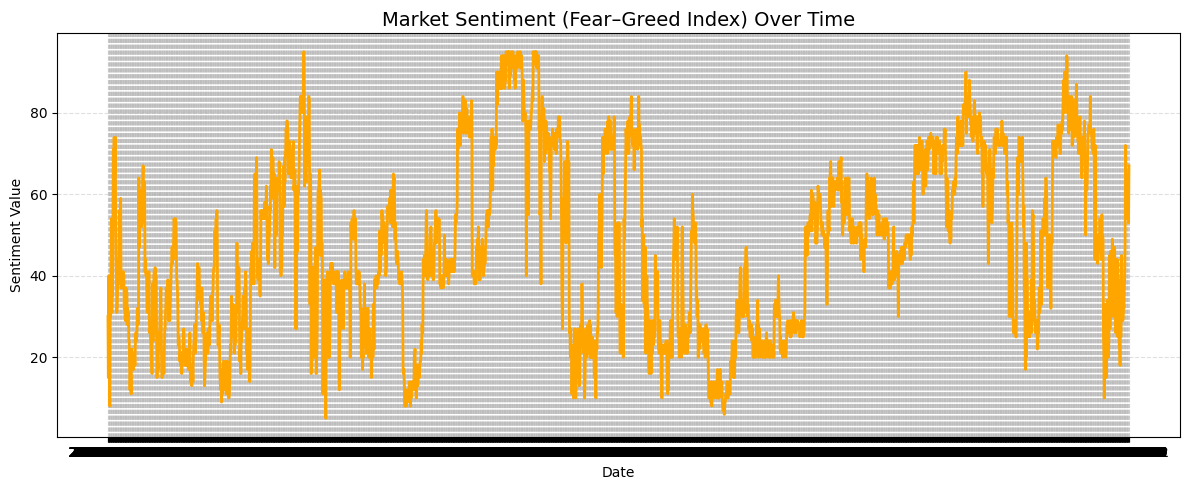

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
sns.lineplot(data=sent, x='date', y='value', color='orange', linewidth=2)
plt.title('Market Sentiment (Fear–Greed Index) Over Time', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Sentiment Value')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


If the line trends upward → market is getting greedier.
Downward → fear increasing.

C:\Users\hitar\AppData\Local\Temp\ipykernel_7976\935031100.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='classification', y='total_pnl', palette='Set2')


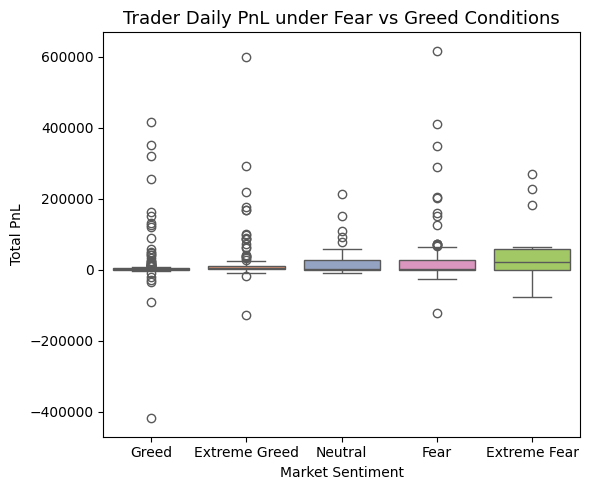

In [29]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=merged, x='classification', y='total_pnl', palette='Set2')
plt.title('Trader Daily PnL under Fear vs Greed Conditions', fontsize=13)
plt.xlabel('Market Sentiment')
plt.ylabel('Total PnL')
plt.tight_layout()
plt.show()


If “Greed” days show higher median PnL → traders perform better when sentiment is optimistic.

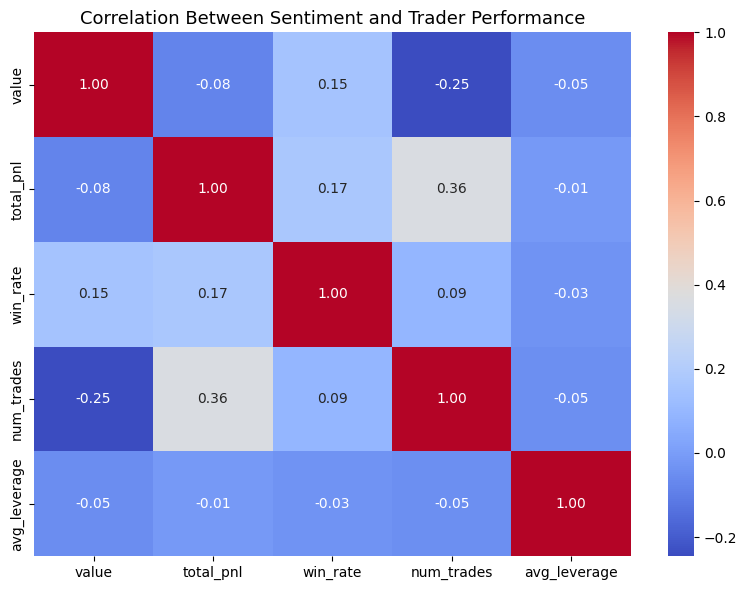

In [31]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    merged[['value', 'total_pnl', 'win_rate', 'num_trades', 'avg_leverage']].corr(),
    annot=True, cmap='coolwarm', fmt=".2f"
)
plt.title('Correlation Between Sentiment and Trader Performance', fontsize=13)
plt.tight_layout()
plt.show()



The strong red block shows strong positive and blue block negative correlation.

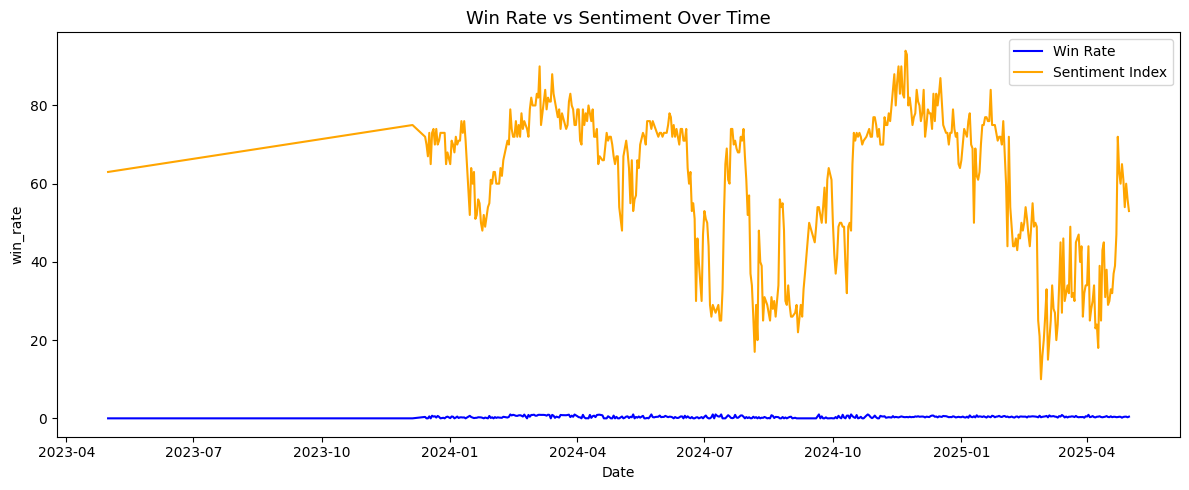

In [33]:
plt.figure(figsize=(12, 5))
sns.lineplot(x='date', y='win_rate', data=merged, label='Win Rate', color='blue')
sns.lineplot(x='date', y='value', data=merged, label='Sentiment Index', color='orange')
plt.title('Win Rate vs Sentiment Over Time', fontsize=13)
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\hitar\AppData\Local\Temp\ipykernel_7976\280696493.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged, x='classification', y='mean_pnl', palette='cool')


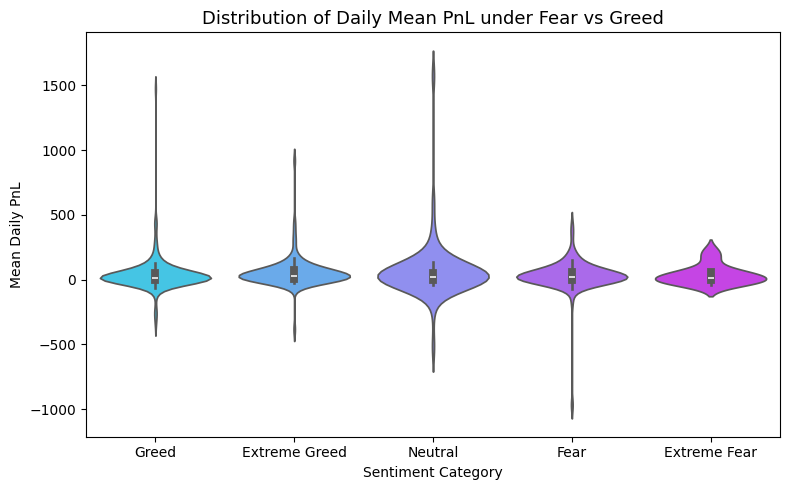

In [34]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=merged, x='classification', y='mean_pnl', palette='cool')
plt.title('Distribution of Daily Mean PnL under Fear vs Greed', fontsize=13)
plt.xlabel('Sentiment Category')
plt.ylabel('Mean Daily PnL')
plt.tight_layout()
plt.show()


## Key Observations :
Negative Profitability Across the Board: The most critical takeaway is that the average trader's Profit and Loss (PnL) is negative regardless of the market sentiment. On average, traders in this dataset are losing money.

"Boring" is Best: Traders experience the smallest average loss during "Neutral" market conditions. This suggests that a less emotional and more stable market leads to better (or at least, less unprofitable) trading decisions.

Emotion is Costly: The largest losses occur during times of high emotion. Specifically:

The worst performance is during periods of "Extreme Fear," where traders realize the largest average losses. This could be due to panic-selling at market bottoms.

High losses also occur during "Greed" and "Extreme Greed." This indicate that traders are buying into hype at market tops (FOMO) and then losing money when the price corrects.